In [1]:
import numpy as np
import cv2
import os 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.utils.np_utils import to_categorical 
from keras.preprocessing.image import ImageDataGenerator
import pickle

## 1-Read Data

In [2]:
path = "data"
folderList = os.listdir(path)
folderList

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [3]:
numOfClasses = len(folderList)
print("Number of Label/Target Class: ", numOfClasses)

Number of Label/Target Class:  10


## 2-Preprocessing

In [4]:
images = []
targetClass = []

    i. Add Images and Target Classes to Lists

In [5]:
for i in range(numOfClasses):
    myImageList = os.listdir(path + "\\" + str(i)) # data\0
    for j in myImageList:
        img = cv2.imread(path + "\\" + str(i) + "\\" + j) # data\0\img001-00001.png
        img = cv2.resize(img, (32,32)) # resize image
        images.append(img) # add images list
        targetClass.append(i) # add class number as target class
        
print(len(images))
print(len(targetClass))

10160
10160


    ii. Converting List to Numpy Array

In [6]:
images = np.array(images)
targetClass = np.array(targetClass)

print(images.shape)
print(targetClass.shape)

(10160, 32, 32, 3)
(10160,)


    iii. Split Data

In [7]:
x_train, x_test, y_train, y_test = train_test_split(images, targetClass, test_size = 0.5, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

print("Images Shape:      ", images.shape)
print("x_train Shape:     ", x_train.shape)
print("x_test Shape:      ", x_test.shape)
print("x_validation Shape:", x_validation.shape)
print("Target Shape:      ", targetClass.shape)
print("y_train Shape:     ", y_train.shape)
print("y_test Shape:      ", y_test.shape)
print("y_validation Shape:", y_validation.shape)

Images Shape:       (10160, 32, 32, 3)
x_train Shape:      (4064, 32, 32, 3)
x_test Shape:       (5080, 32, 32, 3)
x_validation Shape: (1016, 32, 32, 3)
Target Shape:       (10160,)
y_train Shape:      (4064,)
y_test Shape:       (5080,)
y_validation Shape: (1016,)


    iv. Visualize Data

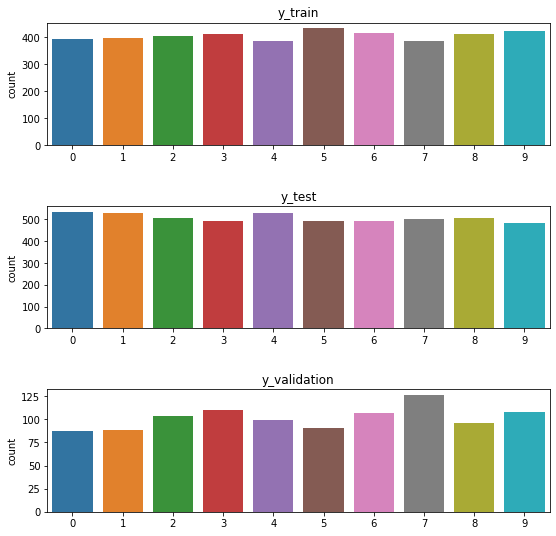

In [8]:
fig, axes = plt.subplots(3,1,figsize=(9,9))
fig.subplots_adjust(hspace = 0.5) # horizontal space (space between rows)

sns.countplot(x = y_train, ax = axes[0])
axes[0].set_title("y_train")

sns.countplot(x = y_test, ax = axes[1])
axes[1].set_title("y_test")

sns.countplot(x = y_validation, ax = axes[2])
axes[2].set_title("y_validation")

plt.show()

    v. Basic Preprocessing Operations

In [9]:
def preProcess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img) # increase contrast => speading values between 0-255
    img = img / 255 # Normalize the values in the image between 0 and 1
    
    return img

In [10]:
# show example image
img = preProcess(x_train[100])
img = cv2.resize(img,(300,300))
cv2.imshow("Preprocess ", img)
while(True):
    if cv2.waitKey(0) == 27: # esc
        cv2.destroyAllWindows()
        False
        break
    else:
        True

In [11]:
# map class'ı: x_train'deki resimlere preProcess fonksiyonunu uygular.
x_train = np.array(list(map(preProcess, x_train))) 
x_test = np.array(list(map(preProcess, x_test)))
x_validation = np.array(list(map(preProcess, x_validation)))

In [12]:
print("x_train Shape:     ", x_train.shape)
print("x_test Shape:      ", x_test.shape)
print("x_validation Shape:", x_validation.shape)

x_train Shape:      (4064, 32, 32)
x_test Shape:       (5080, 32, 32)
x_validation Shape: (1016, 32, 32)


In [13]:
x_train = x_train.reshape(-1,32,32,1)
x_test = x_test.reshape(-1,32,32,1)
x_validation = x_validation.reshape(-1,32,32,1)

print("x_train Shape:     ", x_train.shape)
print("x_test Shape:      ", x_test.shape)
print("x_validation Shape:", x_validation.shape)

x_train Shape:      (4064, 32, 32, 1)
x_test Shape:       (5080, 32, 32, 1)
x_validation Shape: (1016, 32, 32, 1)


    vi. Generate Data

In [14]:
dataGen = ImageDataGenerator(width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             zoom_range = 0.1,
                             rotation_range = 10)

In [15]:
dataGen.fit(x_train)

    vii. Converting Target Class to Categorical (One Hot Encoding)

In [16]:
y_train = to_categorical(y_train, numOfClasses)
y_test = to_categorical(y_test, numOfClasses)
y_validation = to_categorical(y_validation, numOfClasses)

## 3-Create and Compile Model

In [17]:
model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation = "relu", padding = "same", input_shape = (32,32,1))) # samepadding => 1 sıra pixel ekler
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = "relu", padding = "same"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Dropout(rate = 0.2)) # prevent overfitting
model.add(Flatten())
model.add(Dense(units = 256, activation = "relu" ))
model.add(Dropout(rate = 0.2))
model.add(Dense(units = numOfClasses, activation = "softmax" ))

model.compile(loss = "categorical_crossentropy", optimizer=("Adam"), metrics = ["accuracy"])

## 4-Train Data

In [18]:
batch_size = 256
epoch = 15
hist = model.fit(dataGen.flow(x_train, y_train, batch_size = batch_size), 
                                        validation_data = (x_validation, y_validation),
                                        epochs = 15,
                                        steps_per_epoch = x_train.shape[0] // batch_size, 
                                        shuffle = 1)

Epoch 1/15
15/15 [==============================] - 3s 137ms/step - loss: 2.2127 - accuracy: 0.1998 - val_loss: 1.8678 - val_accuracy: 0.4852
Epoch 2/15
15/15 [==============================] - 3s 182ms/step - loss: 1.7701 - accuracy: 0.4640 - val_loss: 1.0135 - val_accuracy: 0.8327
Epoch 3/15
15/15 [==============================] - 3s 181ms/step - loss: 1.2481 - accuracy: 0.6035 - val_loss: 0.5671 - val_accuracy: 0.8593
Epoch 4/15
15/15 [==============================] - 3s 166ms/step - loss: 0.9658 - accuracy: 0.6867 - val_loss: 0.3909 - val_accuracy: 0.9124
Epoch 5/15
15/15 [==============================] - 2s 160ms/step - loss: 0.7785 - accuracy: 0.7576 - val_loss: 0.2862 - val_accuracy: 0.9301
Epoch 6/15
15/15 [==============================] - 2s 158ms/step - loss: 0.6445 - accuracy: 0.8038 - val_loss: 0.2375 - val_accuracy: 0.9380
Epoch 7/15
15/15 [==============================] - 2s 154ms/step - loss: 0.5486 - accuracy: 0.8285 - val_loss: 0.1885 - val_accuracy: 0.9449
Epoch 

## 5-Save Model and History

In [27]:
import json
with open("history.json","w") as f:
    json.dump(hist.history, f) # save history

model.save("model.h5") # save model

## 6-Load Model and History

In [28]:
# load history and model result
import codecs
with codecs.open("history.json", "r",encoding = "utf-8") as f:
    load_hist = json.loads(f.read())

from keras.models import load_model
model1 = load_model("model.h5")

## 6-Evaluate Data

In [21]:
load_hist.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

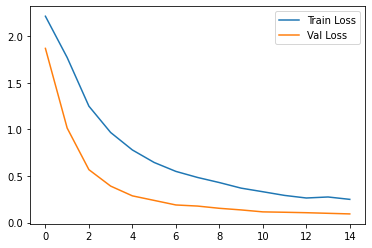

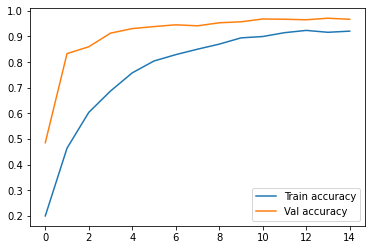

In [22]:
plt.figure()
plt.plot(load_hist["loss"], label = "Train Loss")
plt.plot(load_hist["val_loss"], label = "Val Loss")
plt.legend()

plt.figure()
plt.plot(load_hist["accuracy"], label = "Train accuracy")
plt.plot(load_hist["val_accuracy"], label = "Val accuracy")
plt.legend()

plt.show()

In [23]:
score = model.evaluate(x_test, y_test, verbose = 1)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

159/159 [==============================] - 1s 6ms/step - loss: 0.0826 - accuracy: 0.9736
Test loss:  0.08260826021432877
Test accuracy:  0.9736220240592957


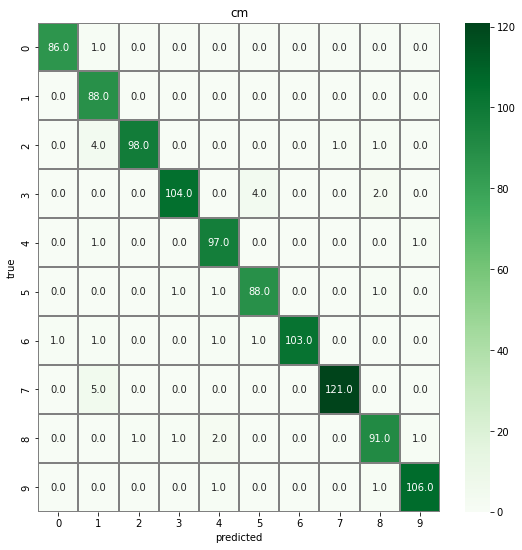

In [24]:
y_pred = model.predict(x_validation)
y_pred_class = np.argmax(y_pred, axis = 1) # değerlerin maximumu bulup indexini bulur.
Y_true = np.argmax(y_validation, axis = 1) # Y_test

cm = confusion_matrix(Y_true, y_pred_class)
f, ax = plt.subplots(figsize=(9,9))
sns.heatmap(cm, annot = True, linewidths = 0.01, cmap = "Greens", linecolor = "gray", fmt = ".1f", ax=ax)
plt.xlabel("predicted")
plt.ylabel("true")
plt.title("cm")
plt.show()

Yukarıdaki plota göre örneğin 8 için:
- 1 tanesini 5 olarak,
- 2 tanesini 6 olarak,
- 92 tanesini 8 olarak tahmin etmiştir.